In [ ]:
import os
import re

import pandas as pd
import numpy as np

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# for this model I changed to google collab in order to use their GPUs

!nvidia-smi

Sat Jan 27 17:42:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# accessing my drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data folders

train_path = '/content/drive/MyDrive/Data/final_project/dataset/train'
valid_path = '/content/drive/MyDrive/Data/final_project/dataset/valid'
test_path = '/content/drive/MyDrive/Data/final_project/dataset/test'

In [ ]:
# creating a dataframe for the train folder with the images and their class

train_images_path = '/content/drive/MyDrive/Data/final_project/dataset/train/images'
image_files_train = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]
class_labels_train = [re.search(r'\d+', file.split('_')[0]).group() for file in image_files_train]
train_df = pd.DataFrame({'filename': image_files_train, 'class': class_labels_train})

# creating a dataframe for the valid folder with the images and their class

valid_images_path = '/content/drive/MyDrive/Data/final_project/dataset/valid/images'
image_files_valid = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]
class_labels_valid = [re.search(r'\d+', file.split('_')[0]).group() for file in image_files_valid]
validation_df = pd.DataFrame({'filename': image_files_valid, 'class': class_labels_valid})

# creating a dataframe for the test folder with the images and their class

test_images_path = '/content/drive/MyDrive/Data/final_project/dataset/test/images'
image_files_test = [file for file in os.listdir(test_images_path) if file.endswith('.jpg')]
class_labels_test = [re.search(r'\d+', file.split('_')[0]).group() for file in image_files_test]
test_df = pd.DataFrame({'filename': image_files_test, 'class': class_labels_test})

In [ ]:
# confirming it has the right structure

train_df['class'].value_counts()

1    433
5    315
0    306
4    299
2    283
3    168
Name: class, dtype: int64

In [ ]:
# real-time data augmentation and preparing the data for training

batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_images_path,
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    directory=valid_images_path,
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='sparse'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_images_path,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 1804 validated image filenames belonging to 6 classes.
Found 173 validated image filenames belonging to 6 classes.
Found 83 validated image filenames.


In [ ]:
# calling the pre trained model, freezing layers of the original model for training, adding my layer, its output, and compiling

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# training the model

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model-dense-net.h5', save_best_only=True)
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, verbose=2, callbacks=[early_stopping, checkpoint] )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 - 120s - loss: 1.4201 - accuracy: 0.4595 - val_loss: 0.9844 - val_accuracy: 0.7283 - 120s/epoch - 2s/step
Epoch 2/20
57/57 - 52s - loss: 1.0591 - accuracy: 0.6242 - val_loss: 0.7980 - val_accuracy: 0.7052 - 52s/epoch - 904ms/step
Epoch 3/20
57/57 - 55s - loss: 0.8637 - accuracy: 0.6962 - val_loss: 0.6927 - val_accuracy: 0.7630 - 55s/epoch - 971ms/step
Epoch 4/20
57/57 - 54s - loss: 0.7692 - accuracy: 0.7373 - val_loss: 0.7761 - val_accuracy: 0.6994 - 54s/epoch - 939ms/step
Epoch 5/20
57/57 - 53s - loss: 0.7200 - accuracy: 0.7256 - val_loss: 0.6452 - val_accuracy: 0.7861 - 53s/epoch - 932ms/step
Epoch 6/20
57/57 - 52s - loss: 0.6570 - accuracy: 0.7594 - val_loss: 0.6638 - val_accuracy: 0.7861 - 52s/epoch - 916ms/step
Epoch 7/20
57/57 - 55s - loss: 0.6330 - accuracy: 0.7672 - val_loss: 0.7024 - val_accuracy: 0.7399 - 55s/epoch - 957ms/step
Epoch 8/20
57/57 - 55s - loss: 0.6030 - accuracy: 0.7761 - val_loss: 0.6886 - val_accuracy: 0.7919 - 55s/epoch - 957ms/step
Epoch 9/20
57/57 - 5

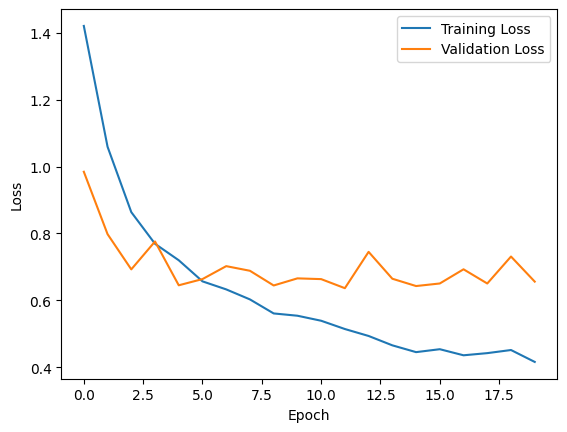

In [ ]:
# plotting the val and training loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# evaluating model on validation set

val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


6/6 [==============================] - 1s 193ms/step - loss: 0.6562 - accuracy: 0.7803
Validation Loss: 0.6561930179595947, Validation Accuracy: 0.7803468108177185


In [ ]:
# making predictions on the test set

test_predictions = model.predict(test_generator)

# printing the predicted class for each test image

test_predicted_classes = np.argmax(test_predictions, axis=1)
test_df['predicted_class'] = test_predicted_classes
print(test_df)



3/3 [==============================] - 18s 8s/step
          filename class  predicted_class
0   2_53395435.jpg     2                2
1   4_06589b88.jpg     4                4
2   1_2da89017.jpg     1                3
3   5_3d203d11.jpg     5                5
4   1_aed57c6b.jpg     1                3
..             ...   ...              ...
78  4_76253060.jpg     4                4
79  4_617cc4fc.jpg     4                4
80  4_3b7bfb6a.jpg     4                4
81  1_96547eff.jpg     1                2
82  4_54f49b99.jpg     4                5

[83 rows x 3 columns]


In [ ]:
# calling the true labels for the test set

true_labels = [int(label) for label in test_df['class']]

# accuracy

accuracy = accuracy_score(true_labels, test_predicted_classes)
print(f'Accuracy: {accuracy:.2%}')

# classification report

print('Classification Report:')
print(classification_report(true_labels, test_predicted_classes))

# confusion matrix

print('Confusion Matrix:')
print(confusion_matrix(true_labels, test_predicted_classes))


Accuracy: 77.11%
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.88      0.68      0.77        22
           2       0.85      0.85      0.85        13
           3       0.38      0.83      0.53         6
           4       0.77      0.71      0.74        14
           5       0.81      0.87      0.84        15

    accuracy                           0.77        83
   macro avg       0.77      0.79      0.76        83
weighted avg       0.81      0.77      0.78        83

Confusion Matrix:
[[10  1  0  1  1  0]
 [ 0 15  1  6  0  0]
 [ 0  0 11  0  1  1]
 [ 0  1  0  5  0  0]
 [ 1  0  1  0 10  2]
 [ 0  0  0  1  1 13]]
